# Question understanding

## Objective

Predict the default based on the datasets.

## Description

There are many information of loanees in datasets, including 148670 loanees and 26 features.  
Our target is to complete the analysis of what sorts of people were likely to default.  
In particular, we need to apply the tools of machine learning to predict which loanee defaulted.

# Data understanding

## Import libraries

These basic libraries will help me to check the structure of tables.

In [441]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold , StratifiedKFold

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

## Functions

These codes are used to execute the programme automatically.

In [563]:
def plot_corr(df):
    corr = df.corr()
    fig,ax = plt.subplots(figsize = (12,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)   
    fig = sns.heatmap(corr, square= True, ax = ax,cmap = cmap,annot = True, 
        annot_kws = { 'fontsize' : 10 })
    plt.tight_layout()
    
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect = 1, height = 3,row = row , col = col )
    facet.map_dataframe( sns.kdeplot , var , shade= True )
    facet.add_legend()
    plt.tight_layout()
    
def plot_proportion( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , height=3, aspect=1.5, row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    plt.tight_layout()
    
def plot_importance_sns(train_set, model):
    _ = pd.DataFrame(model.feature_importances_,columns = ['Importance'],index = train_set.columns)
    _ = _.sort_values(by = ['Importance'],ascending=False)[:15]
    fig,ax = plt.subplots(figsize =(6,8))
    sns.barplot(x="Importance", y="index", data=_.reset_index(), ax = ax)
    ax.legend(['Importance'], fontsize = 15)
    ax.set_ylabel('Features', fontsize = 15)
    ax.set_title('The Importance of features (seaborn)',fontsize = 15)
    
def plot_importance_plt(train_set, model):
    _ = pd.DataFrame(model.feature_importances_,columns = ['Importance'],index = train_set.columns)
    _ = _.sort_values(by = ['Importance'],ascending=True)
    fig,ax = plt.subplots(figsize =(8,20))
    _.plot(kind='barh',color='red',xlim=(0,0.5),figsize=(8,20),legend=True,title='Importance', ax=ax)
    ax.legend(['Importance'],fontsize = 15)
    ax.set_ylabel('Features')
    ax.set_title('The Importance of features (matplotlib)',fontsize = 15)
    
def model_fit(model, X_train, y_train, X_test, y_test, result):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("This is the {} model" .format(str(model).split('(')[0]))
    print("Accuracy score is : {}" .format(accuracy_score(y_test,y_pred)))
    print("F1 score is {}" .format(f1_score(y_test,y_pred,average='binary')))
    print("Model score is {}" .format(model.score(X_test,y_test)))
    result['Accuracy'][str(model).split('(')[0]] = accuracy_score(y_test,y_pred)
    result['F1_score'][str(model).split('(')[0]] = f1_score(y_test,y_pred,average='binary')
    
def plot_metrics(result,title):
    fig,ax = plt.subplots(figsize = (10,6))
    for metrics in result:
        _ = []
        for model in result[metrics]:
            _.append(result[metrics][model])
        ax.plot(_,label = metrics)
    ax.set_xticks(np.arange(len(result['Accuracy'])))
    ax.set_xticklabels(list(result['Accuracy'].keys()),fontsize = 13,rotation = -20)
    ax.set_title('Comparison between different models ({})'.format(str(title)),fontsize = 15)
    ax.legend()
    
def data_scale(column,x_train,x_transed):
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train[column].values.reshape(-1,1))
    x_transed[column] = scaler.transform(x_train[column].values.reshape(-1,1))

# the learning_curve code is referred from the Internet. 
# this is the example taken from: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    print(train_sizes.shape)
    print(train_scores.shape)
    print(test_scores.shape)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("number of samples")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="score on train_set")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="score on test_set")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

def tune(model,X_train,Y_train,score = 'accuracy'):
    tuned_parameters = [{'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [3, 5, 7],
                         'max_features': ["sqrt", "log2", None]}]

    # scores = ['accuracy', 'f1_macro']
    # for score in scores:
    print("# Tuning hyperparameters for %s" % score)
    print("\n")
    cross_validation = StratifiedKFold(n_splits=5)
    clf = GridSearchCV(model, tuned_parameters, cv=cross_validation,
                       scoring= score)
    clf.fit(X_train, Y_train)
    print("Best parameters set found on the training set:")
    print(clf.best_params_)
    print("\n")
    return clf

def optimisation(model_name,result,result_scaled,model_list):
    acc = result['Accuracy'][model_name]
    f1 = result['F1_score'][model_name]
    acc_transformed = result_scaled['Accuracy'][model_name]
    f1_transformed = result_scaled['F1_score'][model_name]
    fig,ax = plt.subplots()
    ax.plot([acc,acc_transformed],label = 'Auuracy',c = 'r')
    ax.plot([f1,f1_transformed],label = 'F1_score',c = 'g')
    ax.legend()
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Raw_model','transformed_model'])
    ax.set_title('Optimisation of {} model'.format(model_name))
    plt.tight_layout()

## Load data

Look at the overview of data sets

In [443]:
datasets = pd.read_csv('default_data.csv')
datasets.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


In [444]:
datasets.shape

(148670, 26)

In [445]:
datasets.dtypes

ID                          int64
year                        int64
loan_limit                 object
Gender                     object
approv_in_adv              object
loan_type                  object
loan_purpose               object
Credit_Worthiness          object
open_credit                object
business_or_commercial     object
loan_amount                 int64
rate_of_interest          float64
Upfront_charges           float64
term                      float64
Neg_ammortization          object
interest_only              object
lump_sum_payment           object
property_value            float64
Secured_by                 object
total_units                object
income                    float64
Credit_Score                int64
age                        object
LTV                       float64
Region                     object
Status                      int64
dtype: object

## Features description

In [446]:
introduction =  pd.read_excel('Dictionary.xlsx',header=0)
# modify column names 
introduction.columns = ['ID','Intro']
introduction = introduction.set_index('ID')
introduction

,Intro
ID,
year,Year loan approved
loan_limit,Upper limit of loan
Gender,"Gender of loanee. ""Joint"" means multiple peopl..."
approv_in_adv,Pre-approved (pre) or not (no-pre)
loan_type,Internal classification (not disclosed)
loan_purpose,Internal classification (not disclosed)
Credit_Worthiness,Internal classification (not disclosed)
open_credit,Borrower can withdraw different amounts up to ...
business_or_commercial,"Busines/commercial loan (""b/c"") or personal lo..."


In [447]:
datasets.columns[1:]

Index(['year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'Secured_by', 'total_units',
       'income', 'Credit_Score', 'age', 'LTV', 'Region', 'Status'],
      dtype='object')

In [448]:
for _ in datasets.columns[1:]:
    print('==== This is the data of new column "{}" ===='.format(_))
    print("The unique value in column {} is \n {} \n" .format(_,datasets[_].value_counts()))

==== This is the data of new column "year" ====
The unique value in column year is 
 2019    148670
Name: year, dtype: int64 

==== This is the data of new column "loan_limit" ====
The unique value in column loan_limit is 
 cf     135348
ncf      9978
Name: loan_limit, dtype: int64 

==== This is the data of new column "Gender" ====
The unique value in column Gender is 
 Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: Gender, dtype: int64 

==== This is the data of new column "approv_in_adv" ====
The unique value in column approv_in_adv is 
 nopre    124621
pre       23141
Name: approv_in_adv, dtype: int64 

==== This is the data of new column "loan_type" ====
The unique value in column loan_type is 
 type1    113173
type2     20762
type3     14735
Name: loan_type, dtype: int64 

==== This is the data of new column "loan_purpose" ====
The unique value in column loan_purpose is 
 p3    55934
p4    54799
p1    34529
p2    

In [449]:
# add a new column to describe unique values in every column
introduction['Unique'] = None
introduction.loc['year','Unique'] = 2019
introduction.loc['loan_limit','Unique'] = [frozenset(('cf','ncf'))]
introduction.loc['Gender','Unique'] = [frozenset(('Male','Joint','Sex Not Available','Female'))]
introduction.loc['approv_in_adv','Unique'] = [frozenset(('nopre','pre'))]
introduction.loc['loan_type','Unique'] = [frozenset(('type1','type2','type3'))]
introduction.loc['loan_purpose','Unique'] = [frozenset(('p1','p2','p3','p4'))]
introduction.loc['Credit_Worthiness','Unique'] = [frozenset(('l1','l2'))]
introduction.loc['open_credit','Unique'] = [frozenset(('opc','nopc'))]
introduction.loc['business_or_commercial','Unique'] = [frozenset(('b/c','nob/c'))]
introduction.loc['loan_amount','Unique'] = None
introduction.loc['rate_of_interest','Unique'] = None
introduction.loc['Upfront_charges','Unique'] = None
introduction.loc['Neg_ammortization','Unique'] = [frozenset(('not_neg','neg_amm'))]
introduction.loc['interest_only','Unique'] = [frozenset(('not_int','int_only'))]
introduction.loc['lump_sum_payment','Unique'] = [frozenset(('not_lpsm','lpsm'))]
introduction.loc['property_value','Unique'] = None
introduction.loc['Secured_by','Unique'] = [frozenset(('home','land'))]
introduction.loc['total_units','Unique'] = [frozenset(('1U','2U','3U','4U'))]
introduction.loc['income','Unique'] = None
introduction.loc['Credit_Score','Unique'] = None
introduction.loc['age','Unique'] = None
introduction.loc['LTV','Unique'] = None
introduction.loc['Region','Unique'] = [frozenset(('North','south','central','North-East'))]
introduction.loc['Status','Unique'] = [frozenset((0,1))]
introduction

,Intro,Unique
ID,,
year,Year loan approved,2019
loan_limit,Upper limit of loan,"(ncf, cf)"
Gender,"Gender of loanee. ""Joint"" means multiple peopl...","(Female, Joint, Sex Not Available, Male)"
approv_in_adv,Pre-approved (pre) or not (no-pre),"(nopre, pre)"
loan_type,Internal classification (not disclosed),"(type3, type2, type1)"
loan_purpose,Internal classification (not disclosed),"(p2, p1, p4, p3)"
Credit_Worthiness,Internal classification (not disclosed),"(l2, l1)"
open_credit,Borrower can withdraw different amounts up to ...,"(nopc, opc)"
business_or_commercial,"Busines/commercial loan (""b/c"") or personal lo...","(b/c, nob/c)"


In [450]:
introduction.reset_index()

,ID,Intro,Unique
0,year,Year loan approved,2019
1,loan_limit,Upper limit of loan,"(ncf, cf)"
2,Gender,"Gender of loanee. ""Joint"" means multiple peopl...","(Female, Joint, Sex Not Available, Male)"
3,approv_in_adv,Pre-approved (pre) or not (no-pre),"(nopre, pre)"
4,loan_type,Internal classification (not disclosed),"(type3, type2, type1)"
5,loan_purpose,Internal classification (not disclosed),"(p2, p1, p4, p3)"
6,Credit_Worthiness,Internal classification (not disclosed),"(l2, l1)"
7,open_credit,Borrower can withdraw different amounts up to ...,"(nopc, opc)"
8,business_or_commercial,"Busines/commercial loan (""b/c"") or personal lo...","(b/c, nob/c)"
9,loan_amount,Amount loaned (£s),None


In [451]:
# It seems that LTV represents the ratio of loan to property, let's see
datasets.loc[:4,['loan_amount','property_value','LTV']]

,loan_amount,property_value,LTV
0,116500,118000.0,98.728814
1,206500,NaN,NaN
2,406500,508000.0,80.019685
3,456500,658000.0,69.376900
4,696500,758000.0,91.886544


In [452]:
print(116500/118000)
print(406500/508000)

0.9872881355932204
0.8001968503937008


Perfect  
Now We all know that $$ LTV = 100 \cdot \frac{loan\_amount}{preperty\_value}$$ 

## Intuition about data

When looking at this data, I can intuitively sense that some characteristics are positively correlated with targets, while some are negatively correlated.

For example, as the LTV gets larger, this means that the smaller the proportion of the loanee's collateral that accounts for the loan, the more likely it is that the loanee will part with the collateral for the loan and thus default on the loan

The following is a list of characteristics that I predict may have a negative and positive correlation with default based on the information above

Positive:  
1. loan_amount
2. rate_of_interest
3. term
4. LTV

Negative:
1. Upfront_charges
2. property_value
3. total_units
4. income
5. credit_score


For consistency with the correlation matrix that follows, the positive here means that the larger the value, the more likely the loanee is to default

This is the intuition of the data set, which may be wrong or right, we coould check it later.

## Statistical summaries and visualisations

In [453]:
datasets.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


### Key information about features

In [454]:
datasets.describe()

,ID,year,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status
count,148670.000000,148670.0,1.486700e+05,112231.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445
std,42917.476598,0.0,1.839093e+05,0.561391,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942
min,24890.000000,2019.0,1.650000e+04,0.000000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000


### A heatmap of correlation

In [455]:
datasets.corr()

,ID,year,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status
ID,1.000000,NaN,-0.000566,0.000442,-0.005507,-0.004056,0.000990,0.002535,-0.001036,-0.005853,0.001703
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amount,-0.000566,NaN,1.000000,-0.150844,0.065556,0.174474,0.734249,0.456065,0.004438,0.038869,-0.036825
rate_of_interest,0.000442,NaN,-0.150844,1.000000,-0.076473,0.209330,-0.122613,-0.041809,-0.001331,-0.000220,0.022957
Upfront_charges,-0.005507,NaN,0.065556,-0.076473,1.000000,-0.054960,0.053043,0.016580,-0.001484,-0.031347,-0.019138
term,-0.004056,NaN,0.174474,0.209330,-0.054960,1.000000,0.045117,-0.053785,-0.003149,0.106834,-0.000240
property_value,0.000990,NaN,0.734249,-0.122613,0.053043,0.045117,1.000000,0.414883,0.002430,-0.215102,-0.048864
income,0.002535,NaN,0.456065,-0.041809,0.016580,-0.053785,0.414883,1.000000,0.000802,-0.066203,-0.065119
Credit_Score,-0.001036,NaN,0.004438,-0.001331,-0.001484,-0.003149,0.002430,0.000802,1.000000,-0.005533,0.004004
LTV,-0.005853,NaN,0.038869,-0.000220,-0.031347,0.106834,-0.215102,-0.066203,-0.005533,1.000000,0.038895


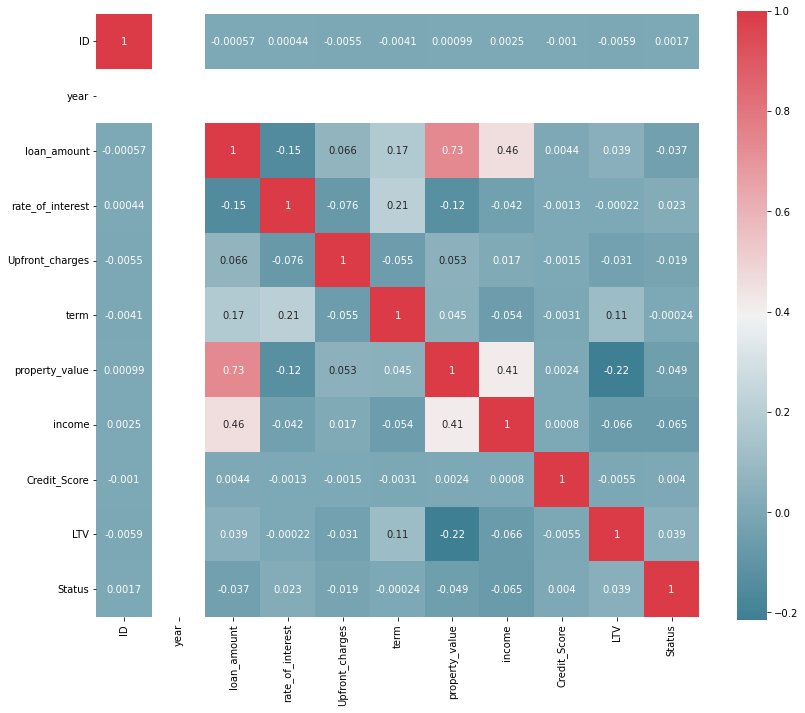

In [456]:
plot_corr(datasets)

### Distribution between 2 features

We can find the features that have a strong influence on status by making a graph

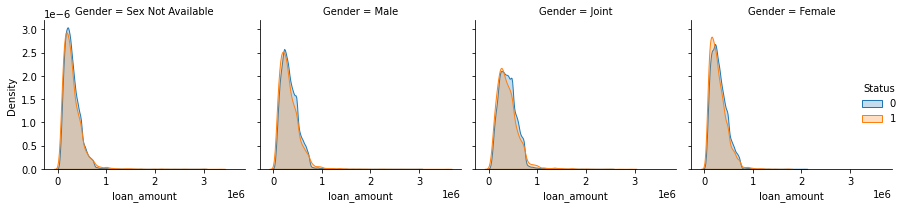

In [457]:
plot_distribution(datasets, 'loan_amount', 'Status', col = 'Gender')

If the distribution of a feature value varies significantly from image to image, then the feature value has an effect on the Status result  
For example, The distributions between different gender groups are different, which means gender is a feature influencing Status massively.

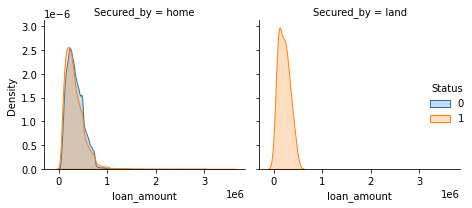

In [458]:
plot_distribution(datasets, 'loan_amount', 'Status', col = 'Secured_by')

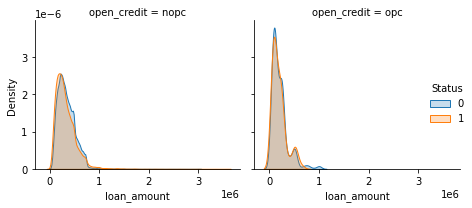

In [459]:
plot_distribution(datasets, 'loan_amount', 'Status', col = 'open_credit')

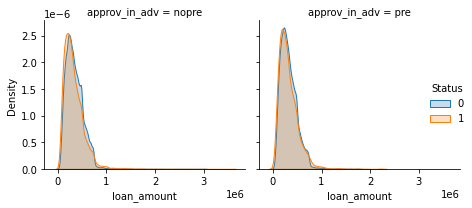

In [460]:
plot_distribution(datasets, 'loan_amount', 'Status', col = 'approv_in_adv')

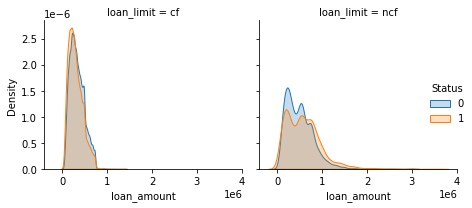

In [461]:
plot_distribution(datasets, 'loan_amount', 'Status', col = 'loan_limit')

### Proportion for 1 feature

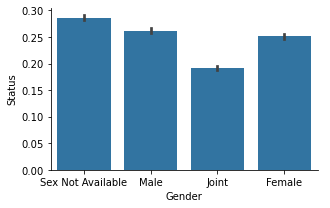

In [462]:
plot_proportion(datasets,'Gender','Status')

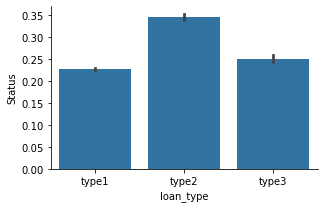

In [463]:
plot_proportion(datasets,'loan_type','Status')

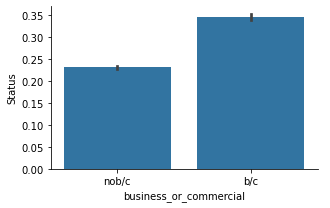

In [464]:
plot_proportion(datasets,'business_or_commercial','Status')

Before start analysing, it seems that there are a lot of missing data in the data set.  
Besides, we need to fransform the categorical variables, such as loan_type and Gender, to numerical variables, to calculate loss function more efficiently. 

# Data Preparation

## X

In [465]:
datasets.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


In [466]:
datasets.year.unique()

array([2019], dtype=int64)

Hence, all data in the dataset are for 2019, but we could not delete this column, because this is the automated data processing file, and this template can also be applied if different years of data are available afterwards, which is robust to varying data inputs.

In [467]:
X = datasets.iloc[:,:]

In [468]:
X.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


## Missing values

In [469]:
X.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,118000.0,home,1U,1740.0,758,25-34,98.728814,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,NaN,home,1U,4980.0,552,55-64,NaN,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,508000.0,home,1U,9480.0,834,35-44,80.019685,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,658000.0,home,1U,11880.0,587,45-54,69.376900,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,758000.0,home,1U,10440.0,602,25-34,91.886544,North,0


In [470]:
# look up missing values
pd.isnull(X).sum()

ID                            0
year                          0
loan_limit                 3344
Gender                        0
approv_in_adv               908
loan_type                     0
loan_purpose                134
Credit_Worthiness             0
open_credit                   0
business_or_commercial        0
loan_amount                   0
rate_of_interest          36439
Upfront_charges           39642
term                         41
Neg_ammortization           121
interest_only                 0
lump_sum_payment              0
property_value            15098
Secured_by                    0
total_units                   0
income                     9150
Credit_Score                  0
age                         200
LTV                       15098
Region                        0
Status                        0
dtype: int64

In [471]:
X.dtypes

ID                          int64
year                        int64
loan_limit                 object
Gender                     object
approv_in_adv              object
loan_type                  object
loan_purpose               object
Credit_Worthiness          object
open_credit                object
business_or_commercial     object
loan_amount                 int64
rate_of_interest          float64
Upfront_charges           float64
term                      float64
Neg_ammortization          object
interest_only              object
lump_sum_payment           object
property_value            float64
Secured_by                 object
total_units                object
income                    float64
Credit_Score                int64
age                        object
LTV                       float64
Region                     object
Status                      int64
dtype: object

In [472]:
# look up missing values (>=5%)
categorial_variables_null = pd.isnull(X).sum()
categorial_variables_null_over = categorial_variables_null[categorial_variables_null>=0.05*X.shape[0]]
categorial_variables_null_over

rate_of_interest    36439
Upfront_charges     39642
property_value      15098
income               9150
LTV                 15098
dtype: int64

In [473]:
# look up missing values (<5%)
categorial_variables_null_below = categorial_variables_null[(categorial_variables_null<0.05*X.shape[0])&(categorial_variables_null>0)]
categorial_variables_null_below

loan_limit           3344
approv_in_adv         908
loan_purpose          134
term                   41
Neg_ammortization     121
age                   200
dtype: int64

In [474]:
print("For the column having missing values more than 5% of all data:\n")
for _ in range(len(categorial_variables_null_over.index)):
    print('The data type of column {} is "{}"' .format(categorial_variables_null_over.index[_], X.dtypes[categorial_variables_null_over.index[_]]))
print('\n')
print("For the column having missing values less than 5% of all data:\n")
for _ in range(len(categorial_variables_null_below.index)):
    print('The data type of column {} is "{}"' .format(categorial_variables_null_below.index[_], X.dtypes[categorial_variables_null_below.index[_]]))

For the column having missing values more than 5% of all data:

The data type of column rate_of_interest is "float64"
The data type of column Upfront_charges is "float64"
The data type of column property_value is "float64"
The data type of column income is "float64"
The data type of column LTV is "float64"


For the column having missing values less than 5% of all data:

The data type of column loan_limit is "object"
The data type of column approv_in_adv is "object"
The data type of column loan_purpose is "object"
The data type of column term is "float64"
The data type of column Neg_ammortization is "object"
The data type of column age is "object"


Hence, we suppose that the proportion of missing values in various columns is similar in this data set and other data sets. It is clear that all columns containing more than 5% of the missing values are of type float64, while the types of columns including less than 5% of the missing values are "object" or "float64"

For columns having missing values more than 5% of all data, we could fill mean/median/mode number  
For columns having missing values less than 5% of all data, we could delete the row

### categorial_variables_null_over

In [475]:
categorial_variables_null_over

rate_of_interest    36439
Upfront_charges     39642
property_value      15098
income               9150
LTV                 15098
dtype: int64

In [476]:
# look at the statistical data
X.loc[:,[_ for _ in categorial_variables_null_over.index]].describe()

,rate_of_interest,Upfront_charges,property_value,income,LTV
count,112231.000000,109028.000000,1.335720e+05,139520.000000,133572.000000
mean,4.045476,3224.996127,4.978935e+05,6957.338876,72.746457
std,0.561391,3251.121510,3.599353e+05,6496.586382,39.967603
min,0.000000,0.000000,8.000000e+03,0.000000,0.967478
25%,3.625000,581.490000,2.680000e+05,3720.000000,60.474860
50%,3.990000,2596.450000,4.180000e+05,5760.000000,75.135870
75%,4.375000,4812.500000,6.280000e+05,8520.000000,86.184211
max,8.000000,60000.000000,1.650800e+07,578580.000000,7831.250000


In [477]:
X[categorial_variables_null_over.index[0]]

0           NaN
1           NaN
2         4.560
3         4.250
4         4.000
          ...  
148665    3.125
148666    5.190
148667    3.125
148668    3.500
148669    4.375
Name: rate_of_interest, Length: 148670, dtype: float64

<AxesSubplot:xlabel='Upfront_charges', ylabel='Density'>

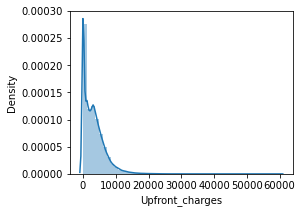

In [478]:
fig,ax = plt.subplots(figsize = (4,3))
sns.distplot(X[categorial_variables_null_over.index[1]],ax=ax)

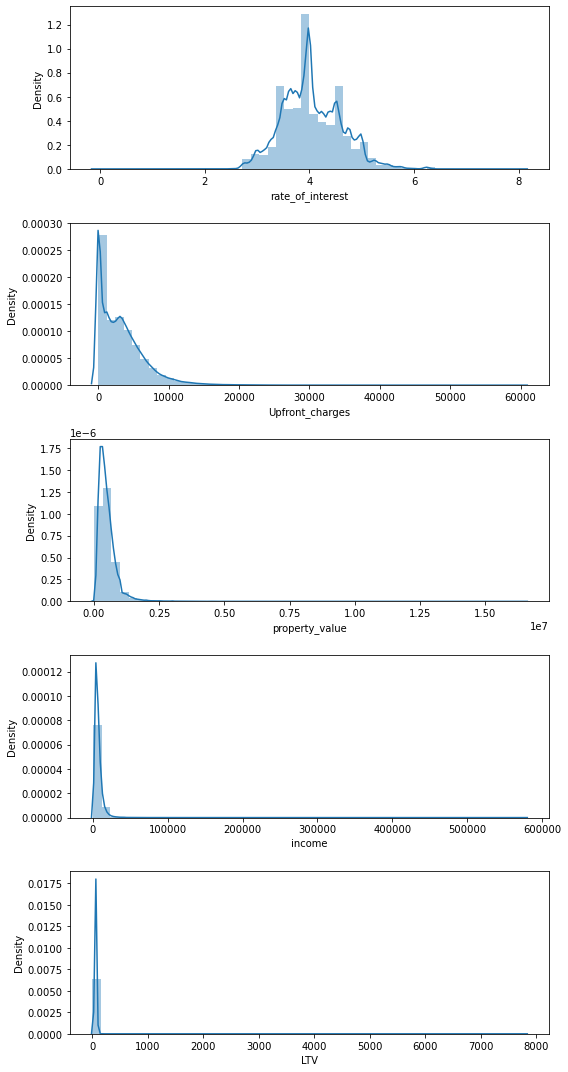

In [479]:
fig,ax = plt.subplots(len(categorial_variables_null_over),1,figsize = (8,3*len(categorial_variables_null_over)))
for _ in range(len(categorial_variables_null_over)):
    sns.distplot(X[categorial_variables_null_over.index[_]],ax=ax[_])
plt.tight_layout()

#### rate_of_interest

For rate_of_interest column, the data distribution is symmetric, we can use the mean value for imputing missing values.

In [480]:
X['rate_of_interest'].fillna(np.mean(X['rate_of_interest']),inplace = True)
assert sum(X['rate_of_interest'].isnull()) == 0

#### Upfront_charges

In [481]:
X.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'Secured_by', 'total_units',
       'income', 'Credit_Score', 'age', 'LTV', 'Region', 'Status'],
      dtype='object')

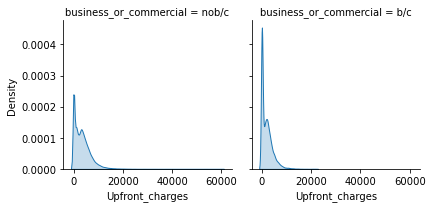

In [482]:
plot_distribution(datasets, 'Upfront_charges', None,  col = 'business_or_commercial')

In [483]:
X.groupby('business_or_commercial')['Upfront_charges'].agg(['mean','median'])

,mean,median
business_or_commercial,,
b/c,1906.411653,1326.105
nob/c,3409.544461,2836.855


Because the data is skewed, use median to fill missing values is more feasible.

In [484]:
X.loc[(X['business_or_commercial'] == 'b/c')&(X['Upfront_charges'].isnull()),'Upfront_charges'] = np.median(X.loc[(X['business_or_commercial']== 'b/c')&(X['Upfront_charges'].notnull()),['Upfront_charges']])
X.loc[(X['business_or_commercial'] == 'nob/c')&(X['Upfront_charges'].isnull()),'Upfront_charges'] = np.median(X.loc[(X['business_or_commercial']== 'nob/c')&(X['Upfront_charges'].notnull()),['Upfront_charges']])

In [485]:
assert sum(X['Upfront_charges'].isnull()) == 0

#### property_value	

For income column, the data distribution is skewed, we can use the np.log function to transform the data.

Text(0.5, 1.0, 'Beofre transforming')

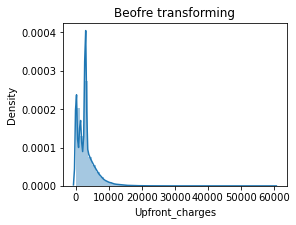

In [486]:
fig,ax = plt.subplots(figsize = (4,3))
sns.distplot((X['Upfront_charges']),ax = ax)
ax.set_title('Beofre transforming')

Text(0.5, 1.0, 'Transformed')

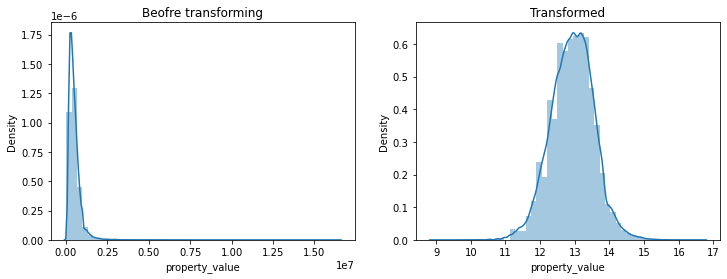

In [487]:
fig,ax = plt.subplots(1,2,figsize = (12,4))
sns.distplot((X['property_value']),ax = ax[0])
ax[0].set_title('Beofre transforming')
X['property_value'] = np.log(X['property_value'])
sns.distplot((X['property_value']),ax = ax[1])
ax[1].set_title('Transformed')

In [488]:
X['property_value'].fillna(np.mean(X['property_value']),inplace = True)
assert sum(X['property_value'].isnull()) == 0

#### income

In [489]:
np.log(X['income'])

0         7.461640
1         8.513185
2         9.156940
3         9.382612
4         9.253400
            ...   
148665    8.969542
148666    8.873468
148667    8.839277
148668    8.873468
148669    8.890135
Name: income, Length: 148670, dtype: float64

In [490]:
sum(X['income'] == 0)

1260

In [491]:
# X = X.loc[X['income']!=0,:].reset_index(drop = True)
X = X.loc[X['income']!=0,:]

It's also skewed, and it has values as 0, we can delete the data has 0

Text(0.5, 1.0, 'Transformed')

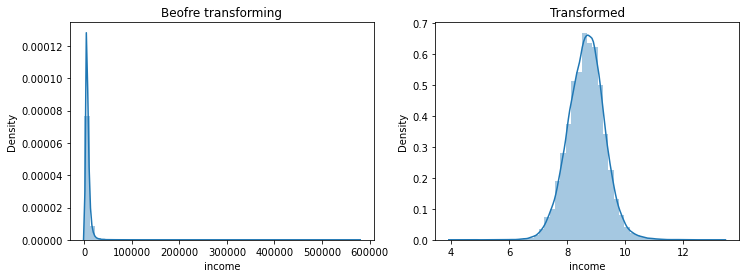

In [492]:
fig,ax = plt.subplots(1,2,figsize = (12,4))
sns.distplot((X['income']),ax = ax[0])
ax[0].set_title('Beofre transforming')
X['income'] = np.log(X['income'])
sns.distplot((X['income']),ax = ax[1])
ax[1].set_title('Transformed')

It's also skewed, and it has values as 0, we can delete the data has 0

In [493]:
X['income'].fillna(np.mean(X['income']),inplace = True)
assert sum(X['income'].isnull()) == 0

#### LTV

As introduced before, we can use this function to calculate the result of LTV

We know that $$ LTV = 100 \cdot \frac{loan\_amount}{preperty\_value}$$ 

In [494]:
X['LTV'] = 100*X['loan_amount']/X['property_value']

In [495]:
X.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,11.678440,home,1U,7.461640,758,25-34,9.975648e+05,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,12.927129,home,1U,8.513185,552,55-64,1.597416e+06,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.138237,home,1U,9.156940,834,35-44,3.094022e+06,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.396960,home,1U,9.382612,587,45-54,3.407489e+06,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.538439,home,1U,9.253400,602,25-34,5.144611e+06,North,0


In [496]:
X.loc[:,[_ for _ in categorial_variables_null_over.index]].isnull().sum()

rate_of_interest    0
Upfront_charges     0
property_value      0
income              0
LTV                 0
dtype: int64

### categorial_variables_null_below

In [497]:
X.loc[:,[_ for _ in categorial_variables_null_below.index]].isnull().sum()

loan_limit           3322
approv_in_adv         904
loan_purpose          134
term                   41
Neg_ammortization     120
age                   200
dtype: int64

In [498]:
X

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,11.678440,home,1U,7.461640,758,25-34,9.975648e+05,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,12.927129,home,1U,8.513185,552,55-64,1.597416e+06,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.138237,home,1U,9.156940,834,35-44,3.094022e+06,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.396960,home,1U,9.382612,587,45-54,3.407489e+06,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.538439,home,1U,9.253400,602,25-34,5.144611e+06,North,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,not_lpsm,13.317930,home,1U,8.969542,659,55-64,3.277536e+06,south,0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.577253,home,4U,8.873468,569,25-34,4.319725e+06,south,0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.498056,home,1U,8.839277,702,45-54,3.307884e+06,North,0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,12.535376,home,1U,8.873468,737,55-64,1.567564e+06,North,0


In [499]:
X.dropna(inplace = True)
X.reset_index(inplace=True,drop = True)
X

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,11.678440,home,1U,7.461640,758,25-34,9.975648e+05,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,12.927129,home,1U,8.513185,552,55-64,1.597416e+06,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.138237,home,1U,9.156940,834,35-44,3.094022e+06,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.396960,home,1U,9.382612,587,45-54,3.407489e+06,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.538439,home,1U,9.253400,602,25-34,5.144611e+06,North,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142704,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,not_lpsm,13.317930,home,1U,8.969542,659,55-64,3.277536e+06,south,0
142705,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.577253,home,4U,8.873468,569,25-34,4.319725e+06,south,0
142706,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.498056,home,1U,8.839277,702,45-54,3.307884e+06,North,0
142707,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,12.535376,home,1U,8.873468,737,55-64,1.567564e+06,North,0


In [500]:
assert sum(X.isnull().sum()) == 0

## Categorical variables

In [501]:
X.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,lump_sum_payment,property_value,Secured_by,total_units,income,Credit_Score,age,LTV,Region,Status
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,not_lpsm,11.678440,home,1U,7.461640,758,25-34,9.975648e+05,south,1
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,lpsm,12.927129,home,1U,8.513185,552,55-64,1.597416e+06,North,1
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.138237,home,1U,9.156940,834,35-44,3.094022e+06,south,0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,not_lpsm,13.396960,home,1U,9.382612,587,45-54,3.407489e+06,North,0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,not_lpsm,13.538439,home,1U,9.253400,602,25-34,5.144611e+06,North,0


In [502]:
X.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'Secured_by', 'total_units',
       'income', 'Credit_Score', 'age', 'LTV', 'Region', 'Status'],
      dtype='object')

In [503]:
X.dtypes

ID                          int64
year                        int64
loan_limit                 object
Gender                     object
approv_in_adv              object
loan_type                  object
loan_purpose               object
Credit_Worthiness          object
open_credit                object
business_or_commercial     object
loan_amount                 int64
rate_of_interest          float64
Upfront_charges           float64
term                      float64
Neg_ammortization          object
interest_only              object
lump_sum_payment           object
property_value            float64
Secured_by                 object
total_units                object
income                    float64
Credit_Score                int64
age                        object
LTV                       float64
Region                     object
Status                      int64
dtype: object

In [504]:
Imputed = pd.DataFrame()
Imputed['loan_amount'] = X['loan_amount']
Imputed['rate_of_interest'] = X['rate_of_interest']
Imputed['Upfront_charges'] = X['Upfront_charges']
Imputed['term'] = X['term']
Imputed['property_value'] = X['property_value']
Imputed['income'] = X['income']
Imputed['Credit_Score'] = X['Credit_Score']
Imputed['LTV'] = X['LTV']
Imputed['Status'] = X['Status']
Imputed

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status
0,116500,4.045476,2836.855,360.0,11.678440,7.461640,758,9.975648e+05,1
1,206500,4.045476,1326.105,360.0,12.927129,8.513185,552,1.597416e+06,1
2,406500,4.560000,595.000,360.0,13.138237,9.156940,834,3.094022e+06,0
3,456500,4.250000,2836.855,360.0,13.396960,9.382612,587,3.407489e+06,0
4,696500,4.000000,0.000,360.0,13.538439,9.253400,602,5.144611e+06,0
...,...,...,...,...,...,...,...,...,...
142704,436500,3.125000,9960.000,180.0,13.317930,8.969542,659,3.277536e+06,0
142705,586500,5.190000,0.000,360.0,13.577253,8.873468,569,4.319725e+06,0
142706,446500,3.125000,1226.640,180.0,13.498056,8.839277,702,3.307884e+06,0
142707,196500,3.500000,4323.330,180.0,12.535376,8.873468,737,1.567564e+06,0


In [505]:
Variables = {}

In [506]:
Variables['ll'] = pd.get_dummies(X.loan_limit, prefix='loan_limit')

In [507]:
Variables['gender'] = pd.get_dummies(X.Gender, prefix='Gender' )

In [508]:
Variables['lt'] = pd.get_dummies(X.loan_type, prefix='Loan_type' )

In [509]:
Variables['lp'] = pd.get_dummies(X.loan_purpose, prefix='Loan_purpose' )

In [510]:
Variables['cw'] = pd.get_dummies(X.Credit_Worthiness, prefix='Credit_Worthiness' )

In [511]:
Variables['oc'] = pd.get_dummies(X.open_credit, prefix='open_credit' )

In [512]:
Variables['bc'] = pd.get_dummies(X.business_or_commercial, prefix='business_or_commercial' )

In [513]:
Variables['na'] = pd.get_dummies(X.Neg_ammortization, prefix='Neg_ammortization' )

In [514]:
Variables['io'] = pd.get_dummies(X.interest_only, prefix='interest_only' )

In [515]:
Variables['lsp'] = pd.get_dummies(X.lump_sum_payment, prefix='lump_sum_payment' )

In [516]:
Variables['sb'] = pd.get_dummies(X.Secured_by, prefix='Secured_by' )

In [517]:
Variables['tb'] = pd.get_dummies(X.total_units, prefix='total_units' )

In [518]:
Variables['age'] = pd.get_dummies(X.age, prefix='age' )

In [519]:
Variables['region'] = pd.get_dummies(X.Region, prefix='Region' )

## Assemble final datasets

### Variable selection

In [523]:
df = pd.concat([Imputed])
for _ in Variables:
    df = pd.concat([df,Variables[_]],axis=1)
df.head()

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,loan_limit_cf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
0,116500,4.045476,2836.855,360.0,11.678440,7.461640,758,9.975648e+05,1,1,...,0,0,0,0,0,0,0,0,0,1
1,206500,4.045476,1326.105,360.0,12.927129,8.513185,552,1.597416e+06,1,1,...,0,0,1,0,0,0,1,0,0,0
2,406500,4.560000,595.000,360.0,13.138237,9.156940,834,3.094022e+06,0,1,...,1,0,0,0,0,0,0,0,0,1
3,456500,4.250000,2836.855,360.0,13.396960,9.382612,587,3.407489e+06,0,1,...,0,1,0,0,0,0,1,0,0,0
4,696500,4.000000,0.000,360.0,13.538439,9.253400,602,5.144611e+06,0,1,...,0,0,0,0,0,0,1,0,0,0


In [524]:
assert sum(df.isnull().sum()) == 0

### Create datasets

In [196]:
df

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,loan_limit_cf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
0,116500,4.045476,2836.855,360.0,11.678440,7.461640,758,9.975648e+05,1,1,...,0,0,0,0,0,0,0,0,0,1
1,206500,4.045476,1326.105,360.0,12.927129,8.513185,552,1.597416e+06,1,1,...,0,0,1,0,0,0,1,0,0,0
2,406500,4.560000,595.000,360.0,13.138237,9.156940,834,3.094022e+06,0,1,...,1,0,0,0,0,0,0,0,0,1
3,456500,4.250000,2836.855,360.0,13.396960,9.382612,587,3.407489e+06,0,1,...,0,1,0,0,0,0,1,0,0,0
4,696500,4.000000,0.000,360.0,13.538439,9.253400,602,5.144611e+06,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142704,436500,3.125000,9960.000,180.0,13.317930,8.969542,659,3.277536e+06,0,1,...,0,0,1,0,0,0,0,0,0,1
142705,586500,5.190000,0.000,360.0,13.577253,8.873468,569,4.319725e+06,0,1,...,0,0,0,0,0,0,0,0,0,1
142706,446500,3.125000,1226.640,180.0,13.498056,8.839277,702,3.307884e+06,0,1,...,0,1,0,0,0,0,1,0,0,0
142707,196500,3.500000,4323.330,180.0,12.535376,8.873468,737,1.567564e+06,0,1,...,0,0,1,0,0,0,1,0,0,0


In [554]:
df_X = df.loc[:,[_ for _ in df.columns if _ != 'Status']]
df_y = df.loc[:,'Status']

In [555]:
# split the data set, 66 is a lunkcy number in China )
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size = 0.6, random_state=66)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(85625, 50)
(85625,)
(57084, 50)
(57084,)


In [199]:
X_train

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit_cf,loan_limit_ncf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
4276,346500,4.045476,1326.105,360.0,12.927129,8.999619,814,2.680410e+06,1,0,...,0,0,1,0,0,0,1,0,0,0
25688,276500,3.625000,9084.380,360.0,13.696727,8.669056,780,2.018730e+06,1,0,...,0,1,0,0,0,0,1,0,0,0
108003,506500,3.500000,0.000,360.0,13.157731,8.914626,514,3.849448e+06,1,0,...,0,0,0,0,0,0,0,0,0,1
124366,296500,3.375000,305.410,360.0,12.730801,8.648120,538,2.328997e+06,1,0,...,1,0,0,0,0,0,1,0,0,0
37093,596500,3.750000,307.300,360.0,13.899852,9.834137,543,4.291413e+06,1,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136271,336500,3.550000,65.560,360.0,12.966878,9.351840,842,2.595073e+06,1,0,...,0,0,0,0,0,0,0,0,0,1
62586,466500,3.990000,14787.500,240.0,13.470199,9.309280,742,3.463200e+06,1,0,...,0,0,1,0,0,0,0,0,0,1
139315,96500,4.045476,2836.855,360.0,11.492723,7.855545,524,8.396618e+05,1,0,...,0,0,0,0,1,0,0,0,0,1
139895,286500,4.045476,2836.855,240.0,13.034624,9.583282,866,2.197992e+06,1,0,...,0,1,0,0,0,0,1,0,0,0


In [200]:
X_test

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit_cf,loan_limit_ncf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
123698,236500,3.990000,4547.000,360.0,12.669807,8.881836,667,1.866643e+06,1,0,...,0,0,0,0,0,1,0,0,0,1
109915,576500,4.375000,22.960,360.0,13.484225,9.320091,526,4.275366e+06,1,0,...,0,0,0,0,0,0,0,0,0,1
138377,496500,4.125000,0.000,360.0,13.762110,9.064158,828,3.607732e+06,1,0,...,0,0,1,0,0,0,1,0,0,0
22890,516500,4.045476,2836.855,360.0,14.407732,9.736252,736,3.584881e+06,1,0,...,0,1,0,0,0,0,1,0,0,0
52898,246500,3.750000,3000.000,360.0,12.637855,8.299037,617,1.950489e+06,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106575,586500,4.045476,2836.855,360.0,13.232114,8.648120,569,4.432398e+06,1,0,...,0,0,0,0,0,1,1,0,0,0
48663,136500,3.750000,3792.940,360.0,12.144197,8.064636,867,1.123994e+06,1,0,...,0,0,0,0,1,0,0,0,0,1
77687,436500,3.625000,818.400,360.0,13.862394,8.594154,739,3.148807e+06,1,0,...,0,0,1,0,0,0,0,0,0,1
119059,396500,4.500000,655.000,360.0,13.034624,8.513185,581,3.041898e+06,1,0,...,0,1,0,0,0,0,0,0,0,1


### Feature importance

In [201]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X_train,y_train)
print(clf.feature_importances_)

[1.19972232e-02 4.62383938e-01 3.17049244e-01 4.19992617e-03
 9.05345401e-02 1.30159366e-02 5.47299885e-03 1.72557963e-02
 8.19636720e-04 7.43486662e-04 5.73528718e-04 1.52264314e-03
 6.87529436e-04 1.42753222e-03 3.84434171e-03 3.86641871e-03
 1.76969273e-03 2.04607786e-03 3.10857886e-04 2.07757285e-03
 2.97759636e-03 2.17066858e-03 1.86970250e-03 9.71063859e-04
 8.23252797e-04 4.57031701e-03 5.63393693e-03 4.47102941e-03
 5.24738785e-03 8.72494120e-04 9.18376592e-04 1.02780212e-02
 1.04818399e-02 3.32096587e-05 4.00718079e-05 3.05860415e-04
 2.15332956e-04 8.19946653e-05 4.97058249e-05 6.44717529e-04
 7.06603994e-04 6.82614341e-04 7.36011467e-04 6.57317745e-04
 1.23978596e-04 3.88078061e-04 1.06749554e-03 1.35376750e-04
 4.37462425e-04 8.09559105e-04]


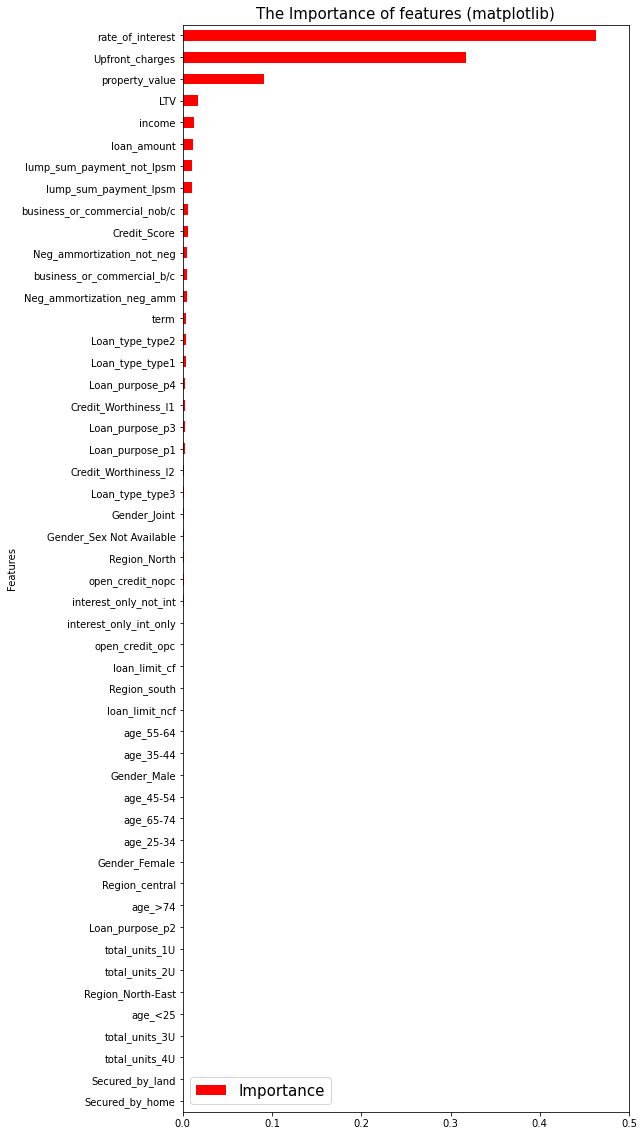

In [202]:
plot_importance_plt(X_train, clf)

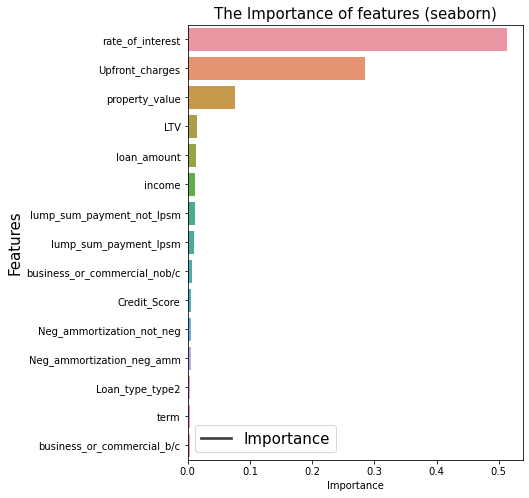

In [564]:
plot_importance_sns(X_train,clf)

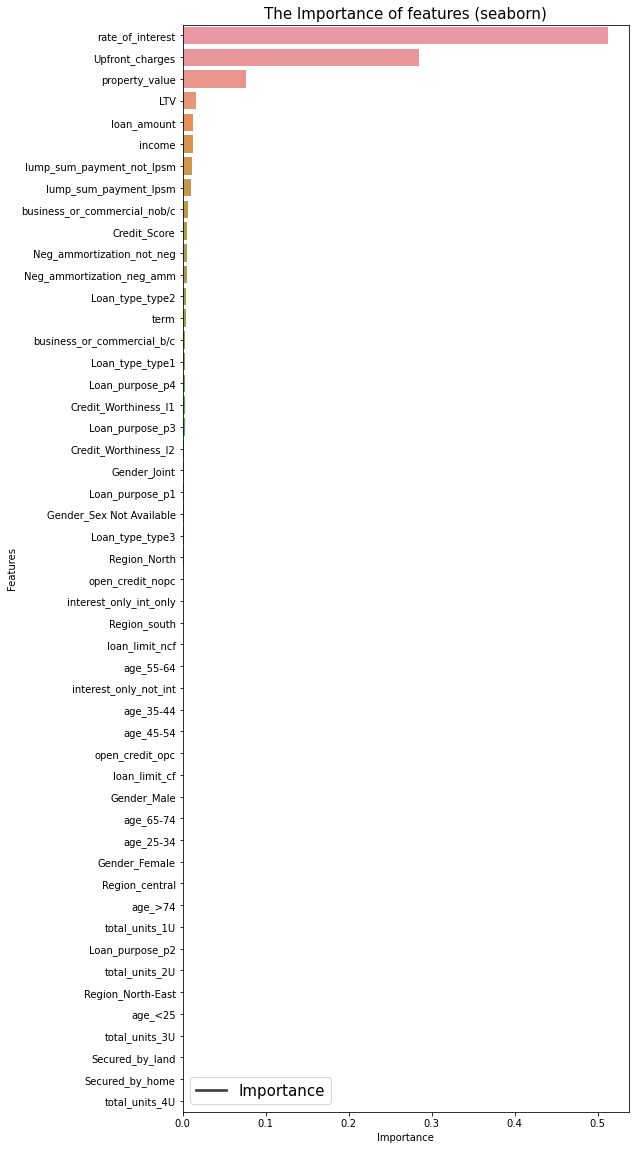

In [556]:
plot_importance_sns(X_train,clf)

In [204]:
print("The real result is : {}" .format(y_test.values))
print("The predict result is : {}" .format(clf.predict(X_test)))

The real result is : [0 0 0 ... 0 0 0]
The predict result is : [0 0 0 ... 0 0 0]


In [205]:
accuracy_score(y_test,clf.predict(X_test))

1.0

In [206]:
f1_score(y_test,clf.predict(X_test),average='binary')

1.0

In [207]:
acc = pd.DataFrame()
acc['true'] = y_test
acc['clf_pred'] = clf.predict(X_test)

In [208]:
acc['clf'] = acc['true'] != acc['clf_pred']
acc

,true,clf_pred,clf
123698,0,0,False
109915,0,0,False
138377,0,0,False
22890,1,1,False
52898,0,0,False
...,...,...,...
106575,1,1,False
48663,0,0,False
77687,0,0,False
119059,0,0,False


In [209]:
print("The number of wrong samples is: {}" .format(sum(acc['clf'])))

The number of wrong samples is: 0


# Feature scaling

While unscaled data can have a significant impact on some distance-sensitive models, such as SVC, KNN, it has little difference on other models, such as Random Forest and Decision Tree. 

Hence I will illustrate the difference based on 2 types of data.

In [210]:
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

In [211]:
for i in range(8):
    data_scale(X_train.columns[i],X_train,X_train_transformed)
    data_scale(X_test.columns[i],X_test,X_test_transformed)

In [212]:
X_train_transformed.head()

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit_cf,loan_limit_ncf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
4276,0.083373,0.010009,-0.612583,0.428731,-0.003655,0.575346,0.989447,0.124104,1,0,...,0,0,1,0,0,0,1,0,0,0
25688,-0.297087,-0.848134,2.133343,0.428731,1.311490,0.034049,0.695772,-0.382295,1,0,...,0,1,0,0,0,0,1,0,0,0
108003,0.952996,-1.103244,-1.081938,0.428731,0.390414,0.436170,-1.601804,1.018798,1,0,...,0,0,0,0,0,0,0,0,0,1
124366,-0.188384,-1.358355,-0.973843,0.428731,-0.339154,-0.000233,-1.394504,-0.144840,1,0,...,1,0,0,0,0,0,1,0,0,0
37093,1.442159,-0.593023,-0.973174,0.428731,1.658604,1.941866,-1.351316,1.357045,1,0,...,1,0,0,0,0,0,0,0,0,1


In [213]:
X_test_transformed.head()

,loan_amount,rate_of_interest,Upfront_charges,term,property_value,income,Credit_Score,LTV,loan_limit_cf,loan_limit_ncf,...,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74,Region_North,Region_North-East,Region_central,Region_south
123698,-0.519765,-0.105494,0.521506,0.425437,-0.447342,0.377253,-0.285168,-0.504813,1,0,...,0,0,0,0,0,1,0,0,0,1
109915,1.323189,0.675041,-1.070904,0.425437,0.941349,1.092289,-1.499846,1.337513,1,0,...,0,0,0,0,0,0,0,0,0,1
138377,0.889553,0.168200,-1.078985,0.425437,1.415180,0.674720,1.101806,0.826869,1,0,...,0,0,1,0,0,0,1,0,0,0
22890,0.997962,0.006976,-0.080445,0.425437,2.516051,1.771276,0.309250,0.809391,1,0,...,0,1,0,0,0,0,1,0,0,0
52898,-0.465560,-0.592061,-0.023020,0.425437,-0.501823,-0.573615,-0.715905,-0.440683,1,0,...,0,0,0,0,0,0,1,0,0,0


# Model

## Unscaled data

In [214]:
# reuslt is used to store the result of every model, to compare the test results of individual models
result = {}
result['Accuracy'] = {}
result['F1_score'] = {}

### Decision Tree 

In [215]:
model = DecisionTreeClassifier(random_state=66)
model = tune(model,X_train,y_train,score = 'f1')
model = DecisionTreeClassifier(**model.best_params_)
model_fit(model, X_train, y_train, X_test, y_test, result)

# Tuning hyperparameters for f1


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_split': 3}


This is the DecisionTreeClassifier model
Accuracy score is : 1.0
F1 score is 1.0
Model score is 1.0


### Random Forest

In [216]:
model_fit(clf, X_train, y_train, X_test, y_test, result)

This is the RandomForestClassifier model
Accuracy score is : 1.0
F1 score is 1.0
Model score is 1.0


### Support Vector Machines

In [295]:
model = SVC()
model_fit(model, X_train, y_train, X_test, y_test, result)

This is the SVC model
Accuracy score is : 0.7611940298507462
F1 score is 0.012173913043478262
Model score is 0.7611940298507462


### K Nearest Neighbor

In [218]:
model = KNeighborsClassifier(n_neighbors = 8)
model_fit(model, X_train, y_train, X_test, y_test, result)

This is the KNeighborsClassifier model
Accuracy score is : 0.884030551468012
F1 score is 0.7405346084502626
Model score is 0.884030551468012


### Gradient Boosting

In [219]:
model = GradientBoostingClassifier()
model_fit(model, X_train, y_train, X_test, y_test, result)

This is the GradientBoostingClassifier model
Accuracy score is : 1.0
F1 score is 1.0
Model score is 1.0


### Bayes

In [220]:
model = GaussianNB()
model_fit(model, X_train, y_train, X_test, y_test, result)

This is the GaussianNB model
Accuracy score is : 0.8305830004905053
F1 score is 0.6950846549169215
Model score is 0.8305830004905053


### Logistics

In [221]:
model = LogisticRegression(penalty='none')
model_fit(model, X_train, y_train, X_test, y_test, result)

This is the LogisticRegression model
Accuracy score is : 0.7610013313713124
F1 score is 0.0019021142731728729
Model score is 0.7610013313713124


### Linear model Lasso

In [222]:
model = Lasso(alpha=0.5)
model.fit(X_train, y_train)

Lasso(alpha=0.5)

In [223]:
model.predict(X_test)

array([0.23200735, 0.27185397, 0.23330504, ..., 0.21117586, 0.29332928,
       0.27450665])

Linear model can not be suitable to classification problem, because the prediction will be numerical rather than variable.

## Unscaled data

In [224]:
# reuslt is used to store the result of every model, to compare the test results of individual modeks
result_scaled = {}
result_scaled['Accuracy'] = {}
result_scaled['F1_score'] = {}

### Decision Tree 

In [225]:
model = DecisionTreeClassifier(random_state=66)
model = tune(model,X_train,y_train,. = 'f1')
model = DecisionTreeClassifier(**model.best_params_)
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

# Tuning hyperparameters for f1


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_split': 3}


This is the DecisionTreeClassifier model
Accuracy score is : 1.0
F1 score is 1.0
Model score is 1.0


### Random Forest

In [226]:
model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the RandomForestClassifier model
Accuracy score is : 0.9830600518534091
F1 score is 0.9632919561173746
Model score is 0.9830600518534091


### Support Vector Machines

In [294]:
model = SVC()
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the SVC model
Accuracy score is : 0.9449933431434377
F1 score is 0.893095465068773
Model score is 0.9449933431434377


### K Nearest Neighbor

In [228]:
model = KNeighborsClassifier(n_neighbors = 8)
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the KNeighborsClassifier model
Accuracy score is : 0.8761299138112255
F1 score is 0.7118699319506132
Model score is 0.8761299138112255


### Gradient Boosting

In [229]:
model = GradientBoostingClassifier()
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the GradientBoostingClassifier model
Accuracy score is : 1.0
F1 score is 1.0
Model score is 1.0


### Bayes

In [230]:
model = GaussianNB()
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the GaussianNB model
Accuracy score is : 0.7610013313713124
F1 score is 0.00175605473037243
Model score is 0.7610013313713124


### Logistics

In [231]:
model = LogisticRegression(penalty='none')
model_fit(model, X_train_transformed, y_train, X_test_transformed, y_test, result_scaled)

This is the LogisticRegression model
Accuracy score is : 0.7857368089131805
F1 score is 0.2740815478663422
Model score is 0.7857368089131805


# Learning curve

The learning curve is very useful to jduge the model is over-fiiting or under-fitting. 

(20,)
(20, 5)
(20, 5)


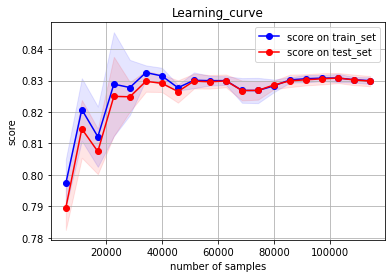

(0.8296154373040012, 0.002813375843956245)

In [291]:
model = GaussianNB()
plot_learning_curve(model,"Learning_curve",df_X, df_y, cv = 5)

# Optimisation

In [296]:
model_list = list(result['Accuracy'].keys())
model_list

['DecisionTreeClassifier',
 'RandomForestClassifier',
 'KNeighborsClassifier',
 'GradientBoostingClassifier',
 'GaussianNB',
 'LogisticRegression',
 'SVC']

## Decision Tree

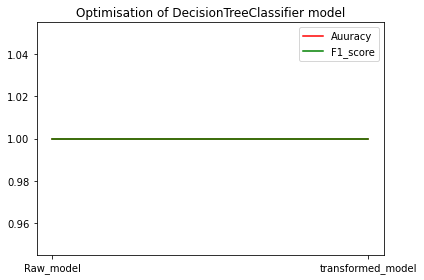

In [297]:
optimisation('DecisionTreeClassifier',result,result_scaled,model_list)

## Random Forest

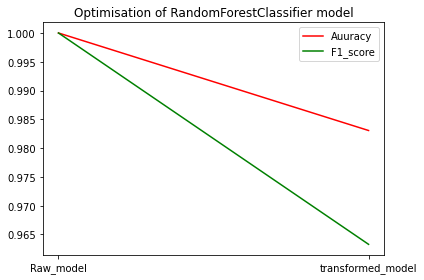

In [298]:
optimisation('RandomForestClassifier',result,result_scaled,model_list)

## Support Vector Machine

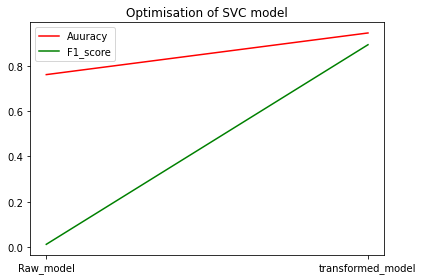

In [299]:
optimisation('SVC',result,result_scaled,model_list)

## K Nearest Neighbor

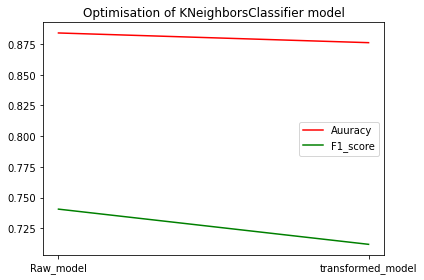

In [300]:
optimisation('KNeighborsClassifier',result,result_scaled,model_list)

## GradientBoosting

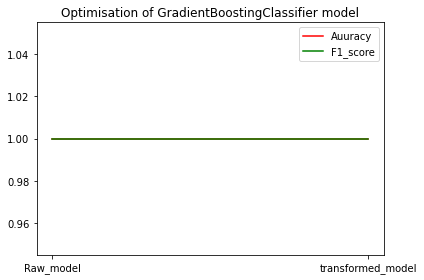

In [301]:
optimisation('GradientBoostingClassifier',result,result_scaled,model_list)

## Bayes

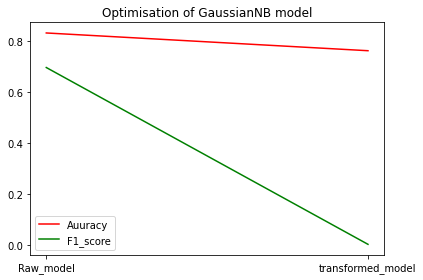

In [302]:
optimisation('GaussianNB',result,result_scaled,model_list)

## Logistics

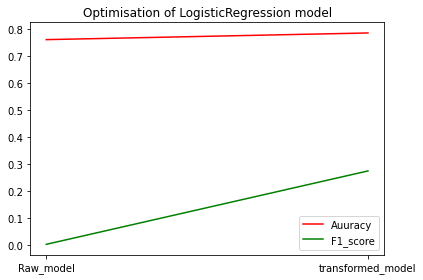

In [303]:
optimisation('LogisticRegression',result,result_scaled,model_list)

# Conclusion

## Unscaled data

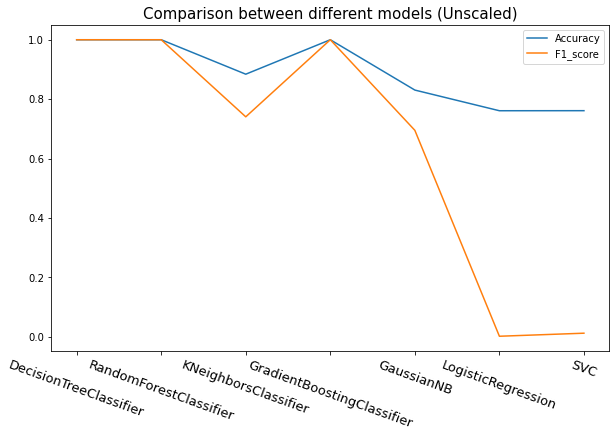

In [304]:
plot_metrics(result,'Unscaled')

## Scaled data

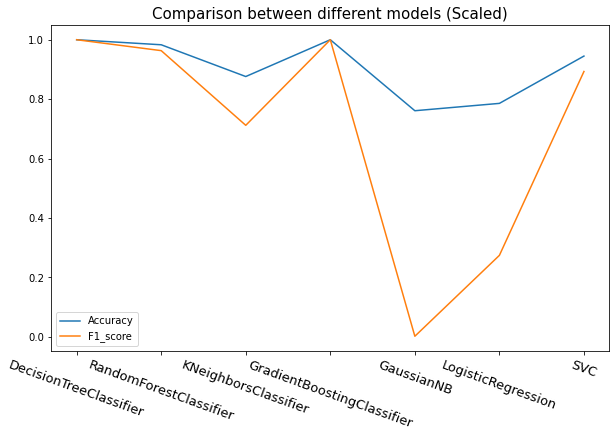

In [305]:
plot_metrics(result_scaled,'Scaled')